In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append('/Users/gbromley/code/python_utilities/')
from python_data_functions import extract_months

In [2]:
data_dir = '/Users/gbromley/data/CRU/pre/'
temp_file = 'cru_ts3.24.1901.2015.pre.dat.nc'

nc_var = xr.open_dataset(data_dir+temp_file)

In [3]:
var = nc_var['pre']

In [4]:
var['time']

<xarray.DataArray 'time' (time: 1380)>
array(['1901-01-16T00:00:00.000000000', '1901-02-15T00:00:00.000000000',
       '1901-03-16T00:00:00.000000000', ..., '2015-10-16T00:00:00.000000000',
       '2015-11-16T00:00:00.000000000', '2015-12-16T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 1901-03-16 ...
Attributes:
    long_name:  time

In [5]:
t_season='AMJJ'
t_months=[4,5,6,7]
start_year = '1970-01-01'
end_year = '2010-12-01'
#coordinates of northern great plains
ext_e = -97
ext_w = -114
ext_n = 55
ext_s = 40


In [6]:
#extract the time period we are interested in
var_slice=var.sel(time=slice(start_year,end_year))
#grab the months interested in
var_months = var_slice.sel(time=extract_months(var_slice['time.month'],t_months[0],t_months[-1]))
#create month averages
var_months_avg = var_months.groupby('time.year').mean(dim='time')

#extract the 30 yr climate normal times
var_clim_30= var.sel(time=slice('1981-01-01','2010-12-01'))
#grab the months
var_clim_months_30 = var_clim_30.sel(time=extract_months(var_clim_30['time.month'],t_months[0],t_months[-1]))
#create averages over months for climate normal
var_clim_months_avg = var_clim_months_30.mean(dim='time')

In [7]:
#create 2d structure to hold slope
spatial_trend = var.isel(time=1).copy(deep=True)
spatial_trend.name = 'pre_trend'
spatial_trend.attrs['units'] = 'mm per Decade'
spatial_trend.attrs['long_name'] = 'precip trend'

#create 2d structure to hold pvalues
pvalues= var.isel(time=1).copy(deep=True)
pvalues.name = 'pre_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = 'precip trend pvalues'

In [8]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
for i in np.arange(0,len(var['lat'])):
    for j in np.arange(0,len(var['lon'])):
        series = var_months_avg[:,i,j]
        anom = series-var_clim_months_avg[i,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(anom)),anom)
        spatial_trend[i,j]=slope*10
        pvalues[i,j]=p_value
        #print(i)

/Users/gbromley/anaconda/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in absolute
  prob = 2 * distributions.t.sf(np.abs(t), df)


In [10]:
spatial_trend.to_dataset().to_netcdf(data_dir+'CRU_pre_trends_'+t_season+'_'+'1970'+'.nc')
pvalues.to_dataset().to_netcdf(data_dir+'CRU_pre_trends_pvalue'+t_season+'_'+'1970'+'.nc')


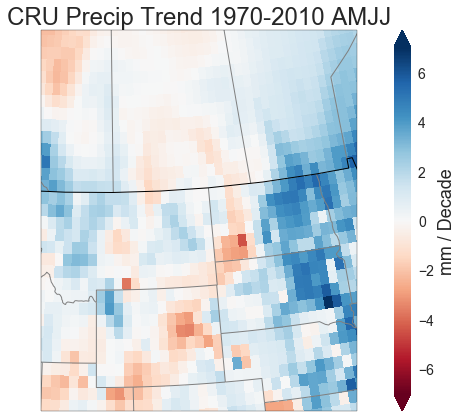

In [12]:
fig, ax = plt.subplots();
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax, transform=ccrs.PlateCarree(),vmin=-7, vmax=7, cmap='RdBu')
#ax = plt.axes(projection=ccrs.LambertConformal())

ax.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.title('CRU Precip Trend 1970-2010 '+t_season,fontsize=24)
test.colorbar.set_label('mm / Decade',fontsize=18)
test.colorbar.ax.tick_params(labelsize=14)
fig.set_size_inches(13,7)
fig.set_dpi=1200.0
plt.savefig('CRU_precip_'+t_season+'_1970.png',bbox_inches='tight')
plt.show()

In [11]:
anom_series = t2m_months - t2m_clim_months_avg
extent = anom_series.sel(lat=np.arange(ext_s,ext_n,step=.5))
extent = extent.sel(lon=np.arange(ext_w+360,ext_e+360,step=.5))
extent_series = extent.mean(dim=['lat','lon'])
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(extent_series)),extent_series.values)
line = slope*np.arange(0,len(extent_series.values))+intercept



fig, ax = plt.subplots();
plt.scatter(extent_series['year'],extent_series.values, c=extent_series.values,vmin=-3,vmax=2,cmap='RdBu_r',s=30);
#trend = ax.plot(anom['time'],line)
base = np.zeros(len(extent_series.values))
ax.plot(extent_series['year'],base,c='grey')
ax.set_title('North America 2m Temperature Anomaly '+t_season+' 1970-2010')
ax.set_xlabel('Year')
ax.set_ylabel('Temp Anomaly [C]')
trend = ax.plot(extent_series['year'],line)
#fig.savefig('2m_temp_anom_'+t_season+'_na_sp_1970.png')



KeyError: "not all values found in index 'lat'"

In [10]:
anom_series

<xarray.DataArray 'tmp' (time: 123, lat: 360, lon: 720)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...